## We solve the MHD toy model with PINN

### The evolution equations are:

$$
\partial_t B^i = \nabla_j (v^j B^i - v^i B^j) \;\;\;\; \nabla_i B^i = 0
$$

The vector field $v^i$ is given. 

And we impose Dirichlet boundary conditions.

The initial data is: 

\begin{align*}
B_1 &= \partial_y \phi \\
B_2 &= -\partial_x \phi
\end{align*}
with (here we use xmin=0, xmax = 1, same for y)

$$
\phi(x,y) = (x*(x-1)*y*(y-1))^2
$$

The velocity field is time-independent and given by:

\begin{align*}
v1(t,x,y) &= \sin(\pi*x)*\cos(\pi*y) \\
v2(t,x,y) &= \cos(\pi*x)*\sin(\pi*y) \\
\end{align*}



In [1]:
using Pkg
Pkg.add(url="https://github.com/psy3nt1st/Optim.jl.git")
using Optim
using NeuralPDE
#using Optimization
using OptimizationOptimJL
using Roots
using LineSearches
using ModelingToolkit, IntervalSets 
using IntervalSets
using Plots, Printf
using Lux, LuxCUDA, ComponentArrays, Random
using JLD2, LinearAlgebra 

const gpud = gpu_device()

@parameters t, x, y
@variables B1(..), B2(..)
Dx = Differential(x)
Dy = Differential(y)
Dt = Differential(t)

    Updating git-repo `https://github.com/psy3nt1st/Optim.jl.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
Precompiling project...
   3171.9 ms  ✓ SummationByPartsOperators → SummationByPartsOperatorsOptimForwardDiffExt
   3761.6 ms  ✓ DiffEqNoiseProcess
  12174.7 ms  ✓ SummationByParts
  18750.6 ms  ✓ OptimizationOptimJL
 107529.2 ms  ✓ ModelingToolkit
   9737.9 ms  ✓ OptimizationBase → OptimizationMTKExt
  15114.3 ms  ✓ NeuralPDE
  7 dependencies successfully precompiled in 140 seconds. 912 already precompiled.
┌ Warning: No functional GPU backend found! Defaulting to CPU.
│ 
│ 1. If no GPU is available, nothing needs to be done. Set `MLDATADEVICES_SILENCE_WARN_NO_GPU=1` to silence this warning.
│ 2. If GPU is available, load the corresponding trigger package.
│     a. `CUDA.jl` and `cuDNN.jl` (or just `LuxCUDA.jl`) for  NVIDIA CUDA Support.
│     b. `AMDGPU.jl` for AMD GPU 

Differential(t)

In [2]:
# Space and time domains
@show domains = [t ∈ Interval(0.0, 4.0),
    x ∈ Interval(0.0, 1.0), y ∈ Interval(0.0, 1.0)]
# Discretization
dx = [0.1, 0.1, 0.1]

domains = [t ∈ Interval(0.0, 4.0), x ∈ Interval(0.0, 1.0), y ∈ Interval(0.0, 1.0)] = Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 4.0), Symbolics.VarDomainPairing(x, 0.0 .. 1.0), Symbolics.VarDomainPairing(y, 0.0 .. 1.0)]


3-element Vector{Float64}:
 0.1
 0.1
 0.1

In [3]:
v1(t,x,y) = -sin(pi*x)
v2(t,x,y) = -sin(pi*y) # with minus is divergence free

phi(x,y) = (x*(x-1)*y*(y-1))^2*64 # to make it zero at the boundaries




phi (generic function with 1 method)

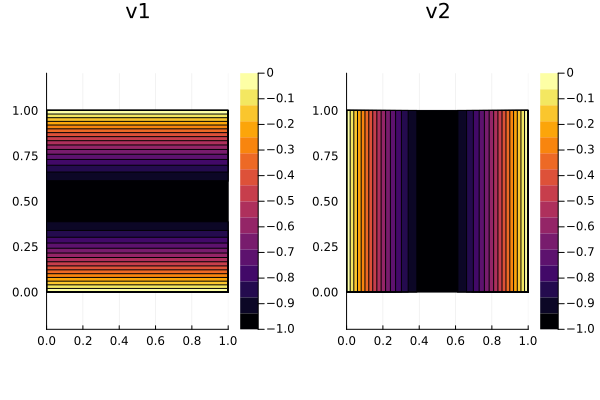

In [4]:
xs, ys = [0.0:0.01:1.0 for d in domains]

v1_d = [v1(0, x, y) for x in xs for y in ys]
v2_d = [v2(0, x, y) for x in xs for y in ys]
pv1 = plot(xs, ys, v1_d, linetype = :contourf, title = "v1", aspect_ratio = 1)
pv2 = plot(xs, ys, v2_d, linetype = :contourf, title = "v2", aspect_ratio = 1)
plot(pv1, pv2, layout = (1,2))

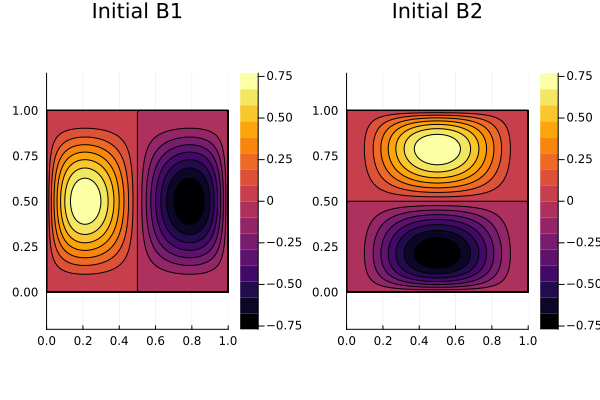

In [5]:
B1_d = [ y*(y-1)*(2y-1)*x^2*(x-1)^2*128 for x in xs for y in ys]
B2_d = [ -x*(x-1)*(2x-1)*y^2*(y-1)^2*128 for x in xs for y in ys]
pv1 = plot(xs, ys, B1_d, linetype = :contourf, title = "Initial B1", aspect_ratio = 1)
pv2 = plot(xs, ys, B2_d, linetype = :contourf, title = "Initial B2", aspect_ratio = 1)
plot(pv1, pv2, layout = (1,2))

In [6]:

eqs = [Dt(B1(t,x,y)) ~ Dy(v2(t,x,y)*B1(t,x,y) - v1(t,x,y)*B2(t,x,y)), 
    Dt(B2(t,x,y)) ~ Dx(v1(t,x,y)*B2(t,x,y) - v2(t,x,y)*B1(t,x,y)), 
    Dx(B1(t,x,y)) + Dy(B2(t,x,y))  ~ 0]


3-element Vector{Equation}:
 Differential(t)(B1(t, x, y)) ~ Differential(y)(sin(πx)*B2(t, x, y) - B1(t, x, y)*sin(πy))
 Differential(t)(B2(t, x, y)) ~ Differential(x)(-sin(πx)*B2(t, x, y) + B1(t, x, y)*sin(πy))
 Differential(y)(B2(t, x, y)) + Differential(x)(B1(t, x, y)) ~ 0

In [7]:

bcs = [B1(0,x,y) ~ Dy(phi(x,y)),
    B2(0,x,y) ~ -Dx(phi(x,y)),
    B1(t,0,y) ~ 0,
    B1(t,1,y) ~ 0,
    B1(t,x,0) ~ 0,
    B1(t,x,1) ~ 0,
    B2(t,0,y) ~ 0,
    B2(t,1,y) ~ 0,
    B2(t,x,0) ~ 0,
    B2(t,x,1) ~ 0]



10-element Vector{Equation}:
 B1(0, x, y) ~ Differential(y)((64//1)*((-1 + x)^2)*(x^2)*((-1 + y)^2)*(y^2))
 B2(0, x, y) ~ -Differential(x)((64//1)*((-1 + x)^2)*(x^2)*((-1 + y)^2)*(y^2))
 B1(t, 0, y) ~ 0
 B1(t, 1, y) ~ 0
 B1(t, x, 0) ~ 0
 B1(t, x, 1) ~ 0
 B2(t, 0, y) ~ 0
 B2(t, 1, y) ~ 0
 B2(t, x, 0) ~ 0
 B2(t, x, 1) ~ 0

In [8]:
# Neural network
input_ = length(domains)
n = 16
chain = [Chain(Dense(input_, n, σ), Dense(n, n, σ), Dense(n, 1)) for _ in 1:2]

#strategy = QuadratureTraining()
strategy = GridTraining(dx)
#ps = Lux.setup(Random.default_rng(), chain)[1]
#ps = ps |> ComponentArray |> gpud .|> Float64
discretization = PhysicsInformedNN(chain, strategy)

@named MHD_toy = PDESystem(eqs, bcs, domains, [t, x, y], [B1(t, x, y), B2(t, x, y)])
prob = discretize(MHD_toy, discretization)
sym_prob = symbolic_discretize(MHD_toy, discretization)

pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions

loss = Float64[]

callback = function (p, l)
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p.u), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p.u), bcs_inner_loss_functions))
    push!(loss, l)
    return false
end

#res = solve(prob, BFGS(linesearch = BackTracking()); maxiters = 1000, callback)
res = solve(prob, SSBroyden(linesearch = BackTracking()); maxiters = 1000, callback)


loss: 5.607886651336074
pde_losses: [1.4396365486640388, 1.3071202979792145, 0.00043783773650598093]
bcs_losses: [0.49104033635472816, 0.32641120557899117, 0.2836683628461976, 0.2507557959767676, 0.253527018536637, 0.2792041978218121, 0.26066284947220525, 0.22758839843532697, 0.2502636841151817, 0.23757011781846693]
loss: 0.45167605513368125
pde_losses: [0.06311029534911167, 0.07425746160337258, 0.0004445838102028455]
bcs_losses: [0.10627688160016999, 0.1095926561728536, 0.009131454035098355, 0.013038883277862623, 0.012819520065255509, 0.0092777889457395, 0.010176811902050036, 0.01674073409161714, 0.011962323822469262, 0.014846660457878141]
loss: 0.43933387375586297
pde_losses: [0.08771522167144531, 0.04559879455717401, 0.00044142271893118207]
bcs_losses: [0.10533015709442832, 0.10504272458234977, 0.012965004781143402, 0.018301001049583782, 0.017871297119294385, 0.013368272113078882, 0.005642419573008747, 0.01077422187283283, 0.00702249274594691, 0.009260843876645365]
loss: 0.222981113

retcode: Failure
u: ComponentVector{Float64}(depvar = (B1 = (layer_1 = (weight = [-1.1506210278277282 -4.626607306864615 -1.7049762873888408; 1.2004972803563156 -2.402751062703157 -0.8756521000867254; … ; -1.1707319821081206 3.022240768205971 -2.9883283803986775; 1.7869705233431472 -2.409704441147268 -6.0851601978539716], bias = [1.3487342226763035, 1.2677683241696376, 19.7325318175092, -2.3770902264567284, -0.7557424812527513, -1.7786019999896245, -2.365769551899819, -9.518894700222162, 1.069556446011736, 4.603367113009874, -0.4848247785542913, -4.092252643062321, -0.44229109044677023, -2.4625474468328687, 2.1554531379021835, 5.067655385452054]), layer_2 = (weight = [-23.75160705684467 1.032686350638603 … 23.1745881365545 13.486608188353761; 11.726046164406306 -30.91237191278027 … 8.231079295272878 -23.90329878164394; … ; -0.14865682425941945 17.91909962702968 … 17.026993385401283 -26.330018137526277; -17.55784261173426 -8.397192456919495 … 16.972984057045224 -21.08024305180222], bias

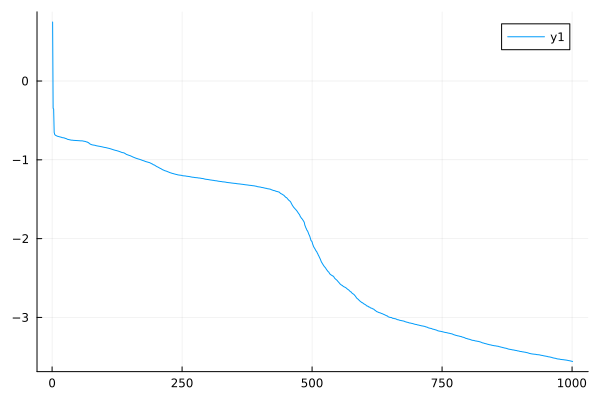

In [10]:
plot(log10.(loss))

In [ ]:
plot!(loss)

In [11]:
phi_d = discretization.phi

2-element Vector{NeuralPDE.Phi{StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}}:
 NeuralPDE.Phi{StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Den

In [ ]:
using JLD2
@save "toy_MHD_2D.jld2" chain res phi_d loss Error

In [ ]:
xs, ys = [0.0:0.01:1.0 for d in domains]
depvars = [:B1, :B2]
minimizers_ = [res.u.depvar[depvars[i]] for i in 1:length(chain)]

t_max = 4.0
u_predict = [phi_d[i]([t, x, y], minimizers_[i])[1] for x in xs for y in ys for i in 1:2]


┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Num}]: A [Base.ReshapedArray{Float64, 2, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}, Tuple{}}] x B [Matrix{Num}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl /Users/reula/.julia/packages/LuxLib/R8Czx/src/impl/matmul.jl:190


In [ ]:
size(u_predict)

In [ ]:

ps = []
for i in 1:2
    p1 = plot(xs, ys, u_predict[:,:,i], linetype = :contourf, title = "predict", aspect_ratio = 1)
    push!(ps, p1)
end

plot(ps[1], ps[2], layout = (1,2))



In [ ]:


function plot_(res)
    # Animate
    anim = @animate for (i, t) in enumerate(0:0.05:t_max)
        @info "Animating frame $i..."
        B1_approx = reshape([Array(phi_d[1]([t, x, y], res.u))[1] for x in xs for y in ys],
            length(xs), length(ys))
        B1_approx = reshape([Array(phi_d[2]([t, x, y], res.u))[1] for x in xs for y in ys],
            length(xs), length(ys))
        title = @sprintf("B1, t = %.3f", t)
        p1 = plot(xs, ys, B1_approx, st = :surface, label = "B1", title = title)
        title = @sprintf("B2, t = %.3f", t)
        p2 = plot(xs, ys, B2_approx, st = :surface, label = "", title = title)
        plot(p1, p2)
    end
    gif(anim, "Toy_MHD_pde.gif", fps = 10)
end

plot_(res)